In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import numpy.lib.stride_tricks as st

# --------------------------------------------------
# Paths and basic configuration
# --------------------------------------------------
PATH = "/content/drive/MyDrive/Datamining-TSC-Project/new_processed_data.parquet"
CFG = {
    "time_col": "time",
    "window": 36,        # sliding window length (hours)
    "trend_h": 12,       # recent hours for trend checks
    "ma_hours": [3, 6, 12],  # moving average windows
}

# --------------------------------------------------
# Angle utility functions
# --------------------------------------------------
def wrap360(x):
    # Wrap angles into [0, 360)
    return (x % 360.0 + 360.0) % 360.0

def angle_diff_deg(a, b):
    # Smallest signed angle difference a - b in degrees
    return (a - b + 180.0) % 360.0 - 180.0

def wave_dir_convert(old_wave_dir):
    # Convert wave direction to wind-direction convention
    return wrap360(270.0 - old_wave_dir)

# --------------------------------------------------
# Moving average feature generator
# --------------------------------------------------
def add_moving_averages(df, cols, ma_hours):
    # Add rolling mean features for selected columns
    for col in cols:
        for h in ma_hours:
            df[f"{col}_ma{h}"] = df[col].rolling(window=h, min_periods=h).mean()
    return df

# --------------------------------------------------
# Load and clean data
# --------------------------------------------------
df = pd.read_parquet(PATH)

df["time"] = pd.to_datetime(df["time"])
df = df.sort_values("time").drop_duplicates("time").reset_index(drop=True)

# Keep only relevant columns
df = df[
    [
        "time",
        "Wind speed",
        "Wind Direction",
        "Wave Period",
        "Wave Direction",
        "Wave Height",
        "Wave Power",
        "Pressure",
        "temperature",
        "Surge Height",
        "Total Water Level",
        "Wave Steepness",
    ]
].copy()

# Rename columns to short, consistent names
df.rename(
    columns={
        "Wind speed": "ws",
        "Wind Direction": "wd",
        "Wave Period": "tp",
        "Wave Direction": "wdir",
        "Wave Height": "hs",
        "Wave Power": "pwr",
        "Pressure": "mslp",
        "temperature": "temp",
        "Surge Height": "surge",
        "Total Water Level": "twl",
        "Wave Steepness": "steep",
    },
    inplace=True,
)

# --------------------------------------------------
# Wind–wave direction alignment features
# --------------------------------------------------
df["wdir"] = wave_dir_convert(df["wdir"].to_numpy(np.float32))

wd = df["wd"].to_numpy(np.float32)
wdir = df["wdir"].to_numpy(np.float32)

# Angle difference between wind and wave directions
dwd_deg = angle_diff_deg(wd, wdir).astype(np.float32)
dwd_rad = np.deg2rad(dwd_deg).astype(np.float32)

# Encode direction difference with sin/cos
df["dwd_sin"] = np.sin(dwd_rad).astype(np.float32)
df["dwd_cos"] = np.cos(dwd_rad).astype(np.float32)

# Drop raw direction columns
df.drop(columns=["wd", "wdir"], inplace=True)

# --------------------------------------------------
# Add moving average features
# --------------------------------------------------
ma_cols = [
    "hs", "ws", "pwr", "mslp",
    "temp", "surge", "twl", "steep", "tp"
]
df = add_moving_averages(df, ma_cols, CFG["ma_hours"])

# --------------------------------------------------
# Sliding window statistics
# --------------------------------------------------
W = CFG["window"]
H = CFG["trend_h"]

hs   = df["hs"].to_numpy(np.float32)
pwr  = df["pwr"].to_numpy(np.float32)
mslp = df["mslp"].to_numpy(np.float32)
ws   = df["ws"].to_numpy(np.float32)
dwd_cos = df["dwd_cos"].to_numpy(np.float32)

# Create rolling windows
hs_w   = st.sliding_window_view(hs,   W)
pwr_w  = st.sliding_window_view(pwr,  W)
mslp_w = st.sliding_window_view(mslp, W)
ws_w   = st.sliding_window_view(ws,   W)
dwd_cos_w = st.sliding_window_view(dwd_cos, W)

# Window-based severity metrics (mean + 2*std)
hs_metric36  = hs_w.mean(axis=1)  + 2.0 * hs_w.std(axis=1)
pwr_metric36 = pwr_w.mean(axis=1) + 2.0 * pwr_w.std(axis=1)

# --------------------------------------------------
# Train / validation / test split by time
# --------------------------------------------------
start_times = df["time"].iloc[:len(hs_metric36)].to_numpy()

train_mask = start_times < np.datetime64("2015-01-01")
val_mask   = (start_times >= np.datetime64("2015-01-01")) & (start_times < np.datetime64("2020-01-01"))
test_mask  = start_times >= np.datetime64("2020-01-01")

# --------------------------------------------------
# Percentile-based severity thresholds (train only)
# --------------------------------------------------
hs_p75, hs_p92, hs_p98, hs_p995 = np.percentile(
    hs_metric36[train_mask], [75, 92, 98, 99.5]
)
pwr_p75, pwr_p92, pwr_p98, pwr_p995 = np.percentile(
    pwr_metric36[train_mask], [75, 92, 98, 99.5]
)

# Map continuous values to severity classes
def severity(x, p75, p92, p98, p995):
    y = np.zeros_like(x, dtype=np.int8)
    y[(x >= p75) & (x < p92)]  = 1
    y[(x >= p92) & (x < p98)]  = 2
    y[(x >= p98) & (x < p995)] = 3
    y[(x >= p995)]             = 4
    return y

sev_hs  = severity(hs_metric36,  hs_p75,  hs_p92,  hs_p98,  hs_p995)
sev_pwr = severity(pwr_metric36, pwr_p75, pwr_p92, pwr_p98, pwr_p995)

# Base severity: worst of wave height or power
base = np.maximum(sev_hs, sev_pwr)

# --------------------------------------------------
# Trend-based reinforcement rules (train only)
# --------------------------------------------------
train_hours_mask = df["time"] < "2015-01-01"

hs_th   = np.percentile(hs[train_hours_mask],  92)
pwr_th  = np.percentile(pwr[train_hours_mask], 92)
ws_th   = np.percentile(ws[train_hours_mask],  92)
mslp_th = np.percentile(mslp[train_hours_mask], 20)
align_th = np.percentile(dwd_cos[train_hours_mask], 75)

# Count how many storm-like conditions persist in last H hours
cnt = (
    (hs_w[:, -H:]  >= hs_th).sum(axis=1)  >= 6
).astype(int) + (
    (pwr_w[:, -H:] >= pwr_th).sum(axis=1) >= 6
).astype(int) + (
    (ws_w[:, -H:]  >= ws_th).sum(axis=1)  >= 6
).astype(int) + (
    (mslp_w[:, -H:] <= mslp_th).sum(axis=1) >= 6
).astype(int) + (
    (dwd_cos_w[:, -H:] >= align_th).sum(axis=1) >= 4
).astype(int)

# Final labels (trend count can be used later if needed)
y = base.copy()

# --------------------------------------------------
# Sanity checks
# --------------------------------------------------
print("Columns:", df.columns.tolist())
print("Class dist:")
for name, m in [("train", train_mask), ("val", val_mask), ("test", test_mask)]:
    print(name, pd.Series(y[m]).value_counts(normalize=True).sort_index().to_dict())


Columns: ['time', 'ws', 'tp', 'hs', 'pwr', 'mslp', 'temp', 'surge', 'twl', 'steep', 'dwd_sin', 'dwd_cos', 'hs_ma3', 'hs_ma6', 'hs_ma12', 'ws_ma3', 'ws_ma6', 'ws_ma12', 'pwr_ma3', 'pwr_ma6', 'pwr_ma12', 'mslp_ma3', 'mslp_ma6', 'mslp_ma12', 'temp_ma3', 'temp_ma6', 'temp_ma12', 'surge_ma3', 'surge_ma6', 'surge_ma12', 'twl_ma3', 'twl_ma6', 'twl_ma12', 'steep_ma3', 'steep_ma6', 'steep_ma12', 'tp_ma3', 'tp_ma6', 'tp_ma12']
Class dist:
train {0: 0.725734690152414, 1: 0.1796986705606766, 2: 0.07084131909585957, 3: 0.017933740987496578, 4: 0.005791579203553284}
val {0: 0.7295774005111354, 1: 0.17819003285870755, 2: 0.06863818912011684, 3: 0.015950164293537787, 4: 0.007644213216502373}
test {0: 0.735375345217173, 1: 0.18250291009517722, 2: 0.060712573893593226, 3: 0.016889964165886836, 4: 0.0045192066281697215}


In [ ]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 11.9 MB/s eta 0:00:00


MA YOK RANDOM FOREST VAR

In [ ]:
import numpy as np
import numpy.lib.stride_tricks as st

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# --------------------------------------------------
# Window length + raw feature list (no moving averages)
# --------------------------------------------------
W = int(W)
COLS = ["ws", "tp", "mslp", "surge", "twl", "steep", "temp", "dwd_sin", "dwd_cos"]
print("Using RAW features (no MAs):", COLS)

# --------------------------------------------------
# Build sliding windows: (num_windows, W, num_features)
# --------------------------------------------------
arrs = [df[c].to_numpy(np.float32) for c in COLS]
X_list = [st.sliding_window_view(a, window_shape=W) for a in arrs]
X = np.stack(X_list, axis=-1).astype(np.float32)

# Labels + split masks (assumed already prepared outside)
y = np.asarray(y)
train_mask = np.asarray(train_mask)
val_mask   = np.asarray(val_mask)
test_mask  = np.asarray(test_mask)

# --------------------------------------------------
# Align lengths (just in case masks/labels are longer)
# --------------------------------------------------
N = min(len(X), len(y), len(train_mask), len(val_mask), len(test_mask))
if (N != len(X)) or (N != len(y)) or (N != len(train_mask)) or (N != len(val_mask)) or (N != len(test_mask)):
    print(f"Aligning lengths -> X:{len(X)} y:{len(y)} "
          f"train:{len(train_mask)} val:{len(val_mask)} test:{len(test_mask)} => N={N}")

X = X[:N]
y = y[:N]
train_mask = train_mask[:N]
val_mask   = val_mask[:N]
test_mask  = test_mask[:N]

# --------------------------------------------------
# Drop windows containing NaN/inf
# --------------------------------------------------
finite_mask = np.isfinite(X).all(axis=(1, 2))
if not finite_mask.all():
    print(f"Dropping {(~finite_mask).sum()} windows due to NaN/inf.")
    X = X[finite_mask]
    y = y[finite_mask]
    train_mask = train_mask[finite_mask]
    val_mask   = val_mask[finite_mask]
    test_mask  = test_mask[finite_mask]

# Split into train/val/test
X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

n_classes = int(np.max(y_train)) + 1
print("Shapes:",
      "\n  X_train:", X_train.shape,
      "\n  X_val:  ", X_val.shape,
      "\n  X_test: ", X_test.shape,
      "\n  #classes:", n_classes)

# --------------------------------------------------
# Standardization using TRAIN only (no leakage)
# (computed over all timesteps in training windows)
# --------------------------------------------------
eps = 1e-6
flat = X_train.reshape(-1, X_train.shape[-1])
mu  = flat.mean(axis=0, keepdims=True)
std = np.maximum(flat.std(axis=0, keepdims=True), eps)

def standardize(Xn):
    return (Xn - mu) / std

X_train = standardize(X_train).astype(np.float32)
X_val   = standardize(X_val).astype(np.float32)
X_test  = standardize(X_test).astype(np.float32)
print("Standardization: ON (train-only).")

# --------------------------------------------------
# MiniROCKET expects (n_instances, n_channels, n_timepoints)
# so we transpose from (N, W, F) -> (N, F, W)
# --------------------------------------------------
X_train_mr = np.transpose(X_train, (0, 2, 1)).astype(np.float32)
X_val_mr   = np.transpose(X_val,   (0, 2, 1)).astype(np.float32)
X_test_mr  = np.transpose(X_test,  (0, 2, 1)).astype(np.float32)

# --------------------------------------------------
# Import MiniROCKET (multivariate if available)
# --------------------------------------------------
try:
    from sktime.transformations.panel.rocket import MiniRocketMultivariate as MiniRocket
except Exception:
    from sktime.transformations.panel.rocket import MiniRocket

mr = MiniRocket(random_state=42)

print("Fitting MiniROCKET on TRAIN ...")
mr.fit(X_train_mr)

print("Transforming ...")
Z_train = mr.transform(X_train_mr)
Z_val   = mr.transform(X_val_mr)
Z_test  = mr.transform(X_test_mr)

# Some sktime transforms return pandas objects -> convert to numpy
def _to_numpy(Z):
    return Z.to_numpy() if hasattr(Z, "to_numpy") else np.asarray(Z)

Z_train = _to_numpy(Z_train)
Z_val   = _to_numpy(Z_val)
Z_test  = _to_numpy(Z_test)

Z_train = Z_train.astype(np.float32, copy=False)
Z_val   = Z_val.astype(np.float32, copy=False)
Z_test  = Z_test.astype(np.float32, copy=False)

print("Transformed shapes:", Z_train.shape, Z_val.shape, Z_test.shape)

# --------------------------------------------------
# Simple param search for RF on top of MiniROCKET features
# (select using validation macro-F1)
# --------------------------------------------------
param_grid = [
    {"n_estimators": 400, "max_depth": None, "min_samples_leaf": 1, "max_features": "sqrt"},
    {"n_estimators": 600, "max_depth": None, "min_samples_leaf": 1, "max_features": "sqrt"},
    {"n_estimators": 600, "max_depth": None, "min_samples_leaf": 2, "max_features": "sqrt"},
    {"n_estimators": 600, "max_depth": 20,   "min_samples_leaf": 1, "max_features": "sqrt"},
    {"n_estimators": 800, "max_depth": 20,   "min_samples_leaf": 2, "max_features": "sqrt"},
]

best_model = None
best_f1 = -1.0
best_params = None

print("Selecting RF params on VAL (macro-F1) ...")
for p in param_grid:
    clf = RandomForestClassifier(
        n_estimators=int(p["n_estimators"]),
        max_depth=p["max_depth"],
        min_samples_leaf=int(p["min_samples_leaf"]),
        max_features=p["max_features"],
        n_jobs=-1,
        class_weight="balanced_subsample",  # helps with imbalance per tree sample
        random_state=42,
        bootstrap=True
    )
    clf.fit(Z_train, y_train.astype(int))
    yp = clf.predict(Z_val)
    f1m = f1_score(y_val.astype(int), yp, average="macro")
    print(f"  {p} | val_f1_macro={f1m:.4f}")

    # Keep the best model based on validation macro-F1
    if f1m > best_f1 + 1e-6:
        best_f1 = f1m
        best_model = clf
        best_params = p

print(f"Best params: {best_params} | best val_f1_macro={best_f1:.4f}")

# --------------------------------------------------
# Final evaluation on each split
# --------------------------------------------------
def report_split(name, Zs, y_true):
    y_pred = best_model.predict(Zs)
    print(f"\n{name}")
    print("F1-macro:", f1_score(y_true, y_pred, average="macro"))
    print(classification_report(y_true, y_pred, zero_division=0))
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

report_split("TRAIN", Z_train, y_train.astype(int))
report_split("VAL",   Z_val,   y_val.astype(int))
report_split("TEST",  Z_test,  y_test.astype(int))


Using RAW features (no MAs): ['ws', 'tp', 'mslp', 'surge', 'twl', 'steep', 'temp', 'dwd_sin', 'dwd_cos']
Shapes: 
  X_train: (262968, 36, 9) 
  X_val:   (43824, 36, 9) 
  X_test:  (43813, 36, 9) 
  #classes: 5
Standardization: ON (train-only).
Fitting MiniROCKET on TRAIN ...
Transforming ...
Transformed shapes: (262968, 9996) (43824, 9996) (43813, 9996)
Selecting RF params on VAL (macro-F1) ...
  {'n_estimators': 400, 'max_depth': None, 'min_samples_leaf': 1, 'max_features': 'sqrt'} | val_f1_macro=0.7674
  {'n_estimators': 600, 'max_depth': None, 'min_samples_leaf': 1, 'max_features': 'sqrt'} | val_f1_macro=0.7670
  {'n_estimators': 600, 'max_depth': None, 'min_samples_leaf': 2, 'max_features': 'sqrt'} | val_f1_macro=0.7811
  {'n_estimators': 600, 'max_depth': None, 'min_samples_leaf': 2, 'max_features': 'sqrt'} | val_f1_macro=0.7811
  {'n_estimators': 600, 'max_depth': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'} | val_f1_macro=0.7755
  {'n_estimators': 600, 'max_depth': 20, 'mi

XGBOOST

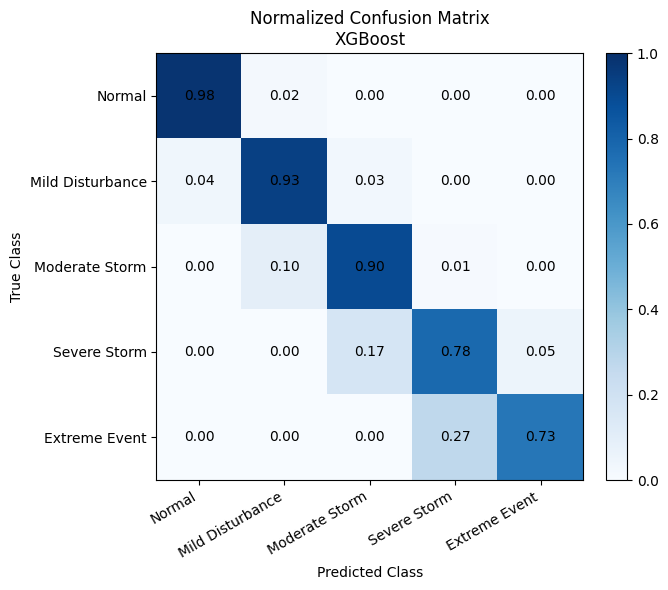

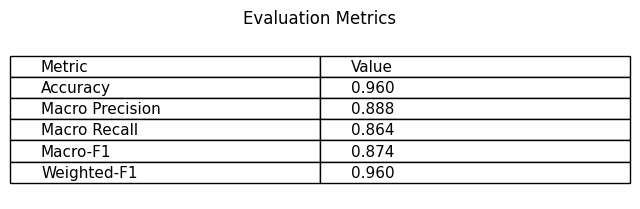

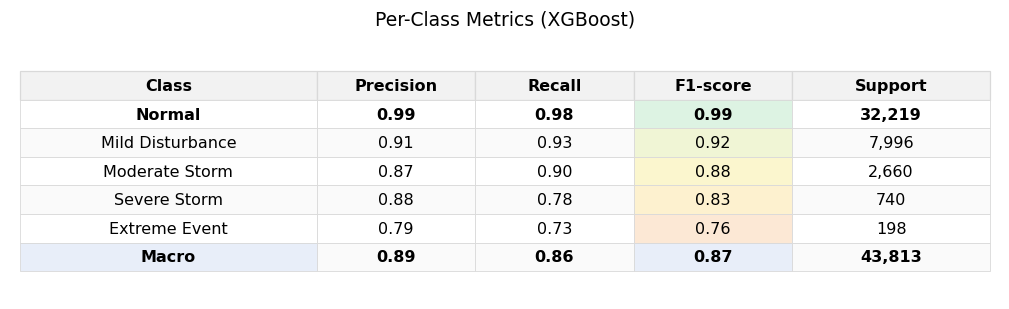

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cm = np.array([
    [31699,  520,    0,   0,   0],
    [  292, 7469,  235,   0,   0],
    [    0,  254, 2383,  23,   0],
    [    0,    0,  125, 576,  39],
    [    0,    0,    0,  54, 144],
], dtype=int)

class_names = [
    "Normal",
    "Mild Disturbance",
    "Moderate Storm",
    "Severe Storm",
    "Extreme Event"
]

metrics = {
    "Accuracy": 0.96,
    "Macro-F1": 0.8744476749685465,
    "Weighted-F1": 0.96,
    "Macro Recall": (0.98 + 0.93 + 0.90 + 0.78 + 0.73) / 5.0,
    "Macro Precision": (0.99 + 0.91 + 0.87 + 0.88 + 0.79) / 5.0,
}

MODEL_TAG  = "xgb"
TITLE_LINE = "XGBoost"


row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm / np.maximum(row_sums, 1)

plt.figure(figsize=(7.2, 6.0))
im = plt.imshow(cm_norm, cmap="Blues", vmin=0.0, vmax=1.0)

plt.title(f"Normalized Confusion Matrix\n{TITLE_LINE}")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

plt.xticks(range(len(class_names)), class_names, rotation=30, ha="right")
plt.yticks(range(len(class_names)), class_names)

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(
            j, i,
            f"{cm_norm[i, j]:.2f}",
            ha="center",
            va="center",
            fontsize=10
        )

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(f"{MODEL_TAG}_test_confusion_matrix_normalized.png", dpi=200)
plt.show()


metrics_df = pd.DataFrame(
    [{"Metric": k, "Value": v} for k, v in metrics.items()]
).sort_values("Metric").reset_index(drop=True)

metrics_df["Value"] = metrics_df["Value"].map(lambda x: f"{x:.3f}")

fig, ax = plt.subplots(figsize=(6.5, 2.2))
ax.axis("off")

table = ax.table(
    cellText=metrics_df.values,
    colLabels=metrics_df.columns,
    cellLoc="left",
    colLoc="left",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.35)

ax.set_title("Evaluation Metrics", pad=12)
plt.tight_layout()
plt.savefig(f"{MODEL_TAG}_test_metrics_table.png", dpi=200)
plt.show()


tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
fn = cm.sum(axis=1) - tp

precision = tp / np.maximum(tp + fp, 1)
recall    = tp / np.maximum(tp + fn, 1)
f1        = 2 * precision * recall / np.maximum(precision + recall, 1e-12)
support   = cm.sum(axis=1)

df = pd.DataFrame({
    "Class": class_names,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "Support": support
})

macro = pd.DataFrame([{
    "Class": "Macro",
    "Precision": df["Precision"].mean(),
    "Recall": df["Recall"].mean(),
    "F1-score": df["F1-score"].mean(),
    "Support": int(df["Support"].sum())
}])

df2 = pd.concat([df, macro], ignore_index=True)

df_fmt = df2.copy()
for c in ["Precision", "Recall", "F1-score"]:
    df_fmt[c] = df_fmt[c].map(lambda x: f"{x:.2f}")
df_fmt["Support"] = df_fmt["Support"].map(
    lambda x: f"{int(x):,}" if isinstance(x, (int, np.integer)) else f"{x:,}"
)

def lerp(a, b, t):
    return a + (b - a) * t

def hex_to_rgb(h):
    h = h.lstrip("#")
    return np.array([int(h[i:i+2], 16) for i in (0, 2, 4)], dtype=float)

def rgb_to_hex(rgb):
    rgb = np.clip(rgb, 0, 255).astype(int)
    return "#{:02x}{:02x}{:02x}".format(*rgb)

C_LOW  = hex_to_rgb("#FCE8D5")
C_MID  = hex_to_rgb("#FFF7CC")
C_HIGH = hex_to_rgb("#DDF3E3")

def f1_color(v, vmin=None, vmax=None):
    if vmin is None: vmin = float(np.min(f1))
    if vmax is None: vmax = float(np.max(f1))
    t = 0.0 if vmax == vmin else (v - vmin) / (vmax - vmin)
    if t < 0.5:
        rgb = lerp(C_LOW, C_MID, t / 0.5)
    else:
        rgb = lerp(C_MID, C_HIGH, (t - 0.5) / 0.5)
    return rgb_to_hex(rgb)

fig, ax = plt.subplots(figsize=(10.2, 3.2))
ax.axis("off")

col_labels = list(df_fmt.columns)
cell_text  = df_fmt.values.tolist()

table = ax.table(
    cellText=cell_text,
    colLabels=col_labels,
    loc="center",
    cellLoc="center",
    colLoc="center",
)

table.auto_set_font_size(False)
table.set_fontsize(11.5)
table.scale(1, 1.65)

col_widths = [0.30, 0.16, 0.16, 0.16, 0.20]
for c, w in enumerate(col_widths):
    for r in range(len(df_fmt) + 1):
        table[(r, c)].set_width(w)

EDGE = "#D9D9D9"
for (r, c), cell in table.get_celld().items():
    cell.set_edgecolor(EDGE)
    cell.set_linewidth(0.6)

    if r == 0:
        cell.set_facecolor("#F2F2F2")
        cell.set_text_props(weight="bold", color="black")
        cell.set_linewidth(0.9)
    else:
        cell.set_facecolor("#FFFFFF" if r % 2 == 1 else "#FAFAFA")

support_col = col_labels.index("Support")
for r in range(1, len(df_fmt) + 1):
    table[(r, support_col)]._loc = "right"
    table[(r, support_col)].PAD = 0.02

f1_col = col_labels.index("F1-score")
best_idx = int(np.argmax(f1))

for i in range(len(df_fmt)):
    r = i + 1
    if df2.loc[i, "Class"] == "Macro":
        table[(r, f1_col)].set_facecolor("#E8EEF9")
        table[(r, 0)].set_text_props(weight="bold")
        table[(r, 0)].set_facecolor("#E8EEF9")
        for cc in range(1, len(col_labels)):
            table[(r, cc)].set_text_props(weight="bold")
        continue

    v = float(df2.loc[i, "F1-score"])
    table[(r, f1_col)].set_facecolor(f1_color(v))

    if i == best_idx:
        for cc in range(len(col_labels)):
            table[(r, cc)].set_text_props(weight="bold")

ax.set_title(f"Per-Class Metrics ({TITLE_LINE})", fontsize=13.5, pad=14)

plt.tight_layout()
plt.savefig(
    f"{MODEL_TAG}_test_per_class_metrics_ultra.png",
    dpi=350,
    bbox_inches="tight",
    facecolor="white"
)
plt.show()


SVM-MA'LI

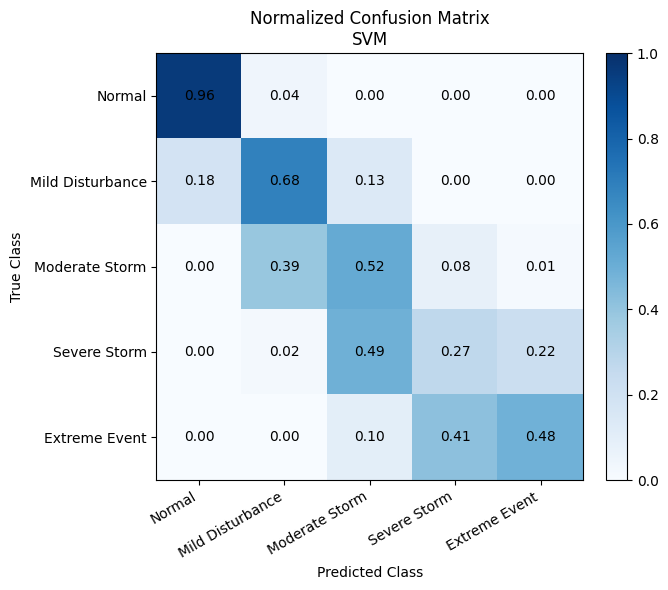

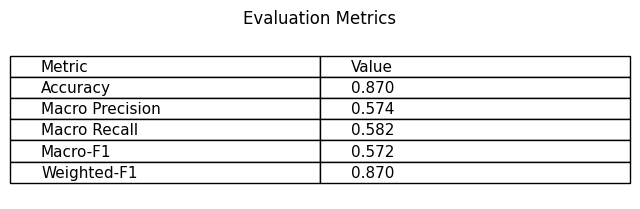

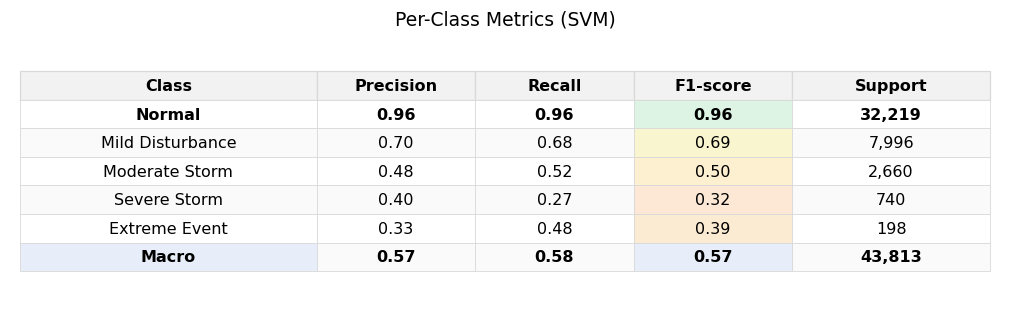

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


cm = np.array([
    [30896, 1268,   53,   2,   0],
    [ 1442, 5475, 1079,   0,   0],
    [    2, 1031, 1374, 218,  35],
    [    0,   15,  362, 200, 163],
    [    0,    0,   20,  82,  96],
], dtype=int)

class_names = [
    "Normal",
    "Mild Disturbance",
    "Moderate Storm",
    "Severe Storm",
    "Extreme Event"
]


metrics = {
    "Accuracy": 0.87,
    "Macro-F1": 0.571691049687114,
    "Weighted-F1": 0.87,
    "Macro Recall": (0.96 + 0.68 + 0.52 + 0.27 + 0.48) / 5.0,
    "Macro Precision": (0.96 + 0.70 + 0.48 + 0.40 + 0.33) / 5.0,
}

MODEL_TAG  = "svm"
TITLE_LINE = "SVM"


row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm / np.maximum(row_sums, 1)

plt.figure(figsize=(7.2, 6.0))
im = plt.imshow(cm_norm, cmap="Blues", vmin=0.0, vmax=1.0)

plt.title(f"Normalized Confusion Matrix\n{TITLE_LINE}")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

plt.xticks(range(len(class_names)), class_names, rotation=30, ha="right")
plt.yticks(range(len(class_names)), class_names)

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(
            j, i,
            f"{cm_norm[i, j]:.2f}",
            ha="center",
            va="center",
            fontsize=10
        )

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(f"{MODEL_TAG}_test_confusion_matrix_normalized.png", dpi=200)
plt.show()


metrics_df = pd.DataFrame(
    [{"Metric": k, "Value": v} for k, v in metrics.items()]
).sort_values("Metric").reset_index(drop=True)

metrics_df["Value"] = metrics_df["Value"].map(lambda x: f"{x:.3f}")

fig, ax = plt.subplots(figsize=(6.5, 2.2))
ax.axis("off")

table = ax.table(
    cellText=metrics_df.values,
    colLabels=metrics_df.columns,
    cellLoc="left",
    colLoc="left",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.35)

ax.set_title("Evaluation Metrics", pad=12)
plt.tight_layout()
plt.savefig(f"{MODEL_TAG}_test_metrics_table.png", dpi=200)
plt.show()


tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
fn = cm.sum(axis=1) - tp

precision = tp / np.maximum(tp + fp, 1)
recall    = tp / np.maximum(tp + fn, 1)
f1        = 2 * precision * recall / np.maximum(precision + recall, 1e-12)
support   = cm.sum(axis=1)

df = pd.DataFrame({
    "Class": class_names,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "Support": support
})

macro = pd.DataFrame([{
    "Class": "Macro",
    "Precision": df["Precision"].mean(),
    "Recall": df["Recall"].mean(),
    "F1-score": df["F1-score"].mean(),
    "Support": int(df["Support"].sum())
}])

df2 = pd.concat([df, macro], ignore_index=True)

df_fmt = df2.copy()
for c in ["Precision", "Recall", "F1-score"]:
    df_fmt[c] = df_fmt[c].map(lambda x: f"{x:.2f}")
df_fmt["Support"] = df_fmt["Support"].map(
    lambda x: f"{int(x):,}" if isinstance(x, (int, np.integer)) else f"{x:,}"
)

def lerp(a, b, t):
    return a + (b - a) * t

def hex_to_rgb(h):
    h = h.lstrip("#")
    return np.array([int(h[i:i+2], 16) for i in (0, 2, 4)], dtype=float)

def rgb_to_hex(rgb):
    rgb = np.clip(rgb, 0, 255).astype(int)
    return "#{:02x}{:02x}{:02x}".format(*rgb)

C_LOW  = hex_to_rgb("#FCE8D5")
C_MID  = hex_to_rgb("#FFF7CC")
C_HIGH = hex_to_rgb("#DDF3E3")

def f1_color(v, vmin=None, vmax=None):
    if vmin is None: vmin = float(np.min(f1))
    if vmax is None: vmax = float(np.max(f1))
    t = 0.0 if vmax == vmin else (v - vmin) / (vmax - vmin)
    if t < 0.5:
        rgb = lerp(C_LOW, C_MID, t / 0.5)
    else:
        rgb = lerp(C_MID, C_HIGH, (t - 0.5) / 0.5)
    return rgb_to_hex(rgb)

fig, ax = plt.subplots(figsize=(10.2, 3.2))
ax.axis("off")

col_labels = list(df_fmt.columns)
cell_text  = df_fmt.values.tolist()

table = ax.table(
    cellText=cell_text,
    colLabels=col_labels,
    loc="center",
    cellLoc="center",
    colLoc="center",
)

table.auto_set_font_size(False)
table.set_fontsize(11.5)
table.scale(1, 1.65)

col_widths = [0.30, 0.16, 0.16, 0.16, 0.20]
for c, w in enumerate(col_widths):
    for r in range(len(df_fmt) + 1):
        table[(r, c)].set_width(w)

EDGE = "#D9D9D9"
for (r, c), cell in table.get_celld().items():
    cell.set_edgecolor(EDGE)
    cell.set_linewidth(0.6)

    if r == 0:
        cell.set_facecolor("#F2F2F2")
        cell.set_text_props(weight="bold", color="black")
        cell.set_linewidth(0.9)
    else:
        cell.set_facecolor("#FFFFFF" if r % 2 == 1 else "#FAFAFA")

support_col = col_labels.index("Support")
for r in range(1, len(df_fmt) + 1):
    table[(r, support_col)]._loc = "right"
    table[(r, support_col)].PAD = 0.02

f1_col = col_labels.index("F1-score")
best_idx = int(np.argmax(f1))

for i in range(len(df_fmt)):
    r = i + 1
    if df2.loc[i, "Class"] == "Macro":
        table[(r, f1_col)].set_facecolor("#E8EEF9")
        table[(r, 0)].set_text_props(weight="bold")
        table[(r, 0)].set_facecolor("#E8EEF9")
        for cc in range(1, len(col_labels)):
            table[(r, cc)].set_text_props(weight="bold")
        continue

    v = float(df2.loc[i, "F1-score"])
    table[(r, f1_col)].set_facecolor(f1_color(v))

    if i == best_idx:
        for cc in range(len(col_labels)):
            table[(r, cc)].set_text_props(weight="bold")

ax.set_title(f"Per-Class Metrics ({TITLE_LINE})", fontsize=13.5, pad=14)

plt.tight_layout()
plt.savefig(
    f"{MODEL_TAG}_test_per_class_metrics_ultra.png",
    dpi=350,
    bbox_inches="tight",
    facecolor="white"
)
plt.show()


MINIROCKET+SDGCLASSIFIER

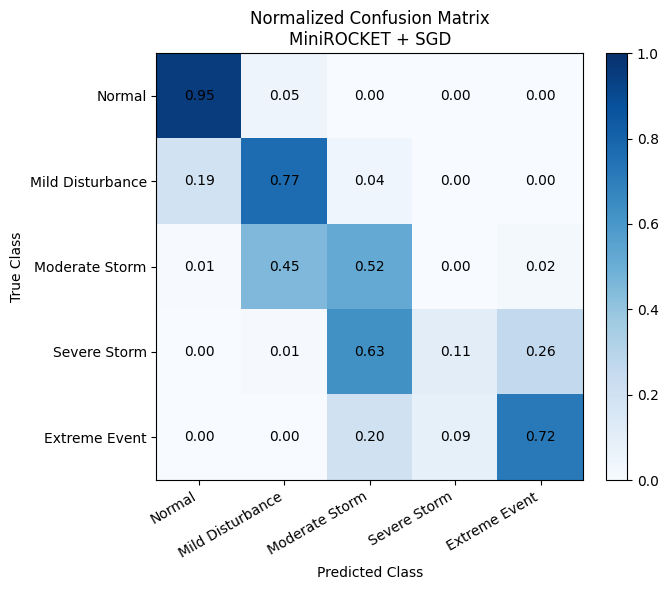

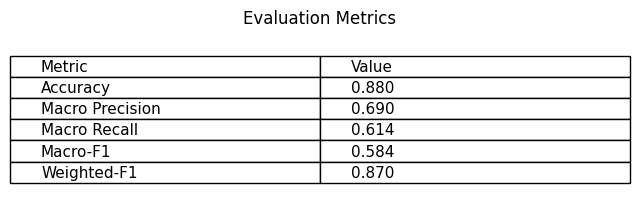

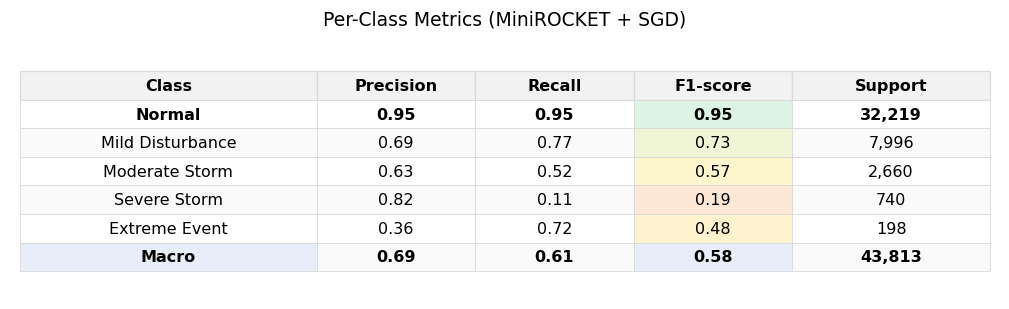

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


cm = np.array([
    [30663, 1556,    0,   0,   0],
    [ 1528, 6152,  316,   0,   0],
    [   20, 1199, 1386,   0,  55],
    [    0,    6,  463,  78, 193],
    [    0,    0,   39,  17, 142],
], dtype=int)

class_names = [
    "Normal",
    "Mild Disturbance",
    "Moderate Storm",
    "Severe Storm",
    "Extreme Event"
]


metrics = {
    "Accuracy": 0.88,
    "Macro-F1": 0.5838408742241675,
    "Weighted-F1": 0.87,
    "Macro Recall": (0.95 + 0.77 + 0.52 + 0.11 + 0.72) / 5.0,
    "Macro Precision": (0.95 + 0.69 + 0.63 + 0.82 + 0.36) / 5.0,
}

MODEL_TAG  = "minirocket_sgd"
TITLE_LINE = "MiniROCKET + SGD"


row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm / np.maximum(row_sums, 1)

plt.figure(figsize=(7.2, 6.0))
im = plt.imshow(cm_norm, cmap="Blues", vmin=0.0, vmax=1.0)

plt.title(f"Normalized Confusion Matrix\n{TITLE_LINE}")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

plt.xticks(range(len(class_names)), class_names, rotation=30, ha="right")
plt.yticks(range(len(class_names)), class_names)

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(
            j, i,
            f"{cm_norm[i, j]:.2f}",
            ha="center",
            va="center",
            fontsize=10
        )

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(f"{MODEL_TAG}_test_confusion_matrix_normalized.png", dpi=200)
plt.show()


metrics_df = pd.DataFrame(
    [{"Metric": k, "Value": v} for k, v in metrics.items()]
).sort_values("Metric").reset_index(drop=True)

metrics_df["Value"] = metrics_df["Value"].map(lambda x: f"{x:.3f}")

fig, ax = plt.subplots(figsize=(6.5, 2.2))
ax.axis("off")

table = ax.table(
    cellText=metrics_df.values,
    colLabels=metrics_df.columns,
    cellLoc="left",
    colLoc="left",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.35)

ax.set_title("Evaluation Metrics", pad=12)
plt.tight_layout()
plt.savefig(f"{MODEL_TAG}_test_metrics_table.png", dpi=200)
plt.show()


tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
fn = cm.sum(axis=1) - tp

precision = tp / np.maximum(tp + fp, 1)
recall    = tp / np.maximum(tp + fn, 1)
f1        = 2 * precision * recall / np.maximum(precision + recall, 1e-12)
support   = cm.sum(axis=1)

df = pd.DataFrame({
    "Class": class_names,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "Support": support
})

macro = pd.DataFrame([{
    "Class": "Macro",
    "Precision": df["Precision"].mean(),
    "Recall": df["Recall"].mean(),
    "F1-score": df["F1-score"].mean(),
    "Support": int(df["Support"].sum())
}])

df2 = pd.concat([df, macro], ignore_index=True)

df_fmt = df2.copy()
for c in ["Precision", "Recall", "F1-score"]:
    df_fmt[c] = df_fmt[c].map(lambda x: f"{x:.2f}")
df_fmt["Support"] = df_fmt["Support"].map(
    lambda x: f"{int(x):,}" if isinstance(x, (int, np.integer)) else f"{x:,}"
)

def lerp(a, b, t):
    return a + (b - a) * t

def hex_to_rgb(h):
    h = h.lstrip("#")
    return np.array([int(h[i:i+2], 16) for i in (0, 2, 4)], dtype=float)

def rgb_to_hex(rgb):
    rgb = np.clip(rgb, 0, 255).astype(int)
    return "#{:02x}{:02x}{:02x}".format(*rgb)

C_LOW  = hex_to_rgb("#FCE8D5")
C_MID  = hex_to_rgb("#FFF7CC")
C_HIGH = hex_to_rgb("#DDF3E3")

def f1_color(v, vmin=None, vmax=None):
    if vmin is None: vmin = float(np.min(f1))
    if vmax is None: vmax = float(np.max(f1))
    t = 0.0 if vmax == vmin else (v - vmin) / (vmax - vmin)
    if t < 0.5:
        rgb = lerp(C_LOW, C_MID, t / 0.5)
    else:
        rgb = lerp(C_MID, C_HIGH, (t - 0.5) / 0.5)
    return rgb_to_hex(rgb)

fig, ax = plt.subplots(figsize=(10.2, 3.2))
ax.axis("off")

col_labels = list(df_fmt.columns)
cell_text  = df_fmt.values.tolist()

table = ax.table(
    cellText=cell_text,
    colLabels=col_labels,
    loc="center",
    cellLoc="center",
    colLoc="center",
)

table.auto_set_font_size(False)
table.set_fontsize(11.5)
table.scale(1, 1.65)

col_widths = [0.30, 0.16, 0.16, 0.16, 0.20]
for c, w in enumerate(col_widths):
    for r in range(len(df_fmt) + 1):
        table[(r, c)].set_width(w)

EDGE = "#D9D9D9"
for (r, c), cell in table.get_celld().items():
    cell.set_edgecolor(EDGE)
    cell.set_linewidth(0.6)

    if r == 0:
        cell.set_facecolor("#F2F2F2")
        cell.set_text_props(weight="bold", color="black")
        cell.set_linewidth(0.9)
    else:
        cell.set_facecolor("#FFFFFF" if r % 2 == 1 else "#FAFAFA")

support_col = col_labels.index("Support")
for r in range(1, len(df_fmt) + 1):
    table[(r, support_col)]._loc = "right"
    table[(r, support_col)].PAD = 0.02

f1_col = col_labels.index("F1-score")
best_idx = int(np.argmax(f1))

for i in range(len(df_fmt)):
    r = i + 1
    if df2.loc[i, "Class"] == "Macro":
        table[(r, f1_col)].set_facecolor("#E8EEF9")
        table[(r, 0)].set_text_props(weight="bold")
        table[(r, 0)].set_facecolor("#E8EEF9")
        for cc in range(1, len(col_labels)):
            table[(r, cc)].set_text_props(weight="bold")
        continue

    v = float(df2.loc[i, "F1-score"])
    table[(r, f1_col)].set_facecolor(f1_color(v))

    if i == best_idx:
        for cc in range(len(col_labels)):
            table[(r, cc)].set_text_props(weight="bold")

ax.set_title(f"Per-Class Metrics ({TITLE_LINE})", fontsize=13.5, pad=14)

plt.tight_layout()
plt.savefig(
    f"{MODEL_TAG}_test_per_class_metrics_ultra.png",
    dpi=350,
    bbox_inches="tight",
    facecolor="white"
)
plt.show()


Minirocket + RF

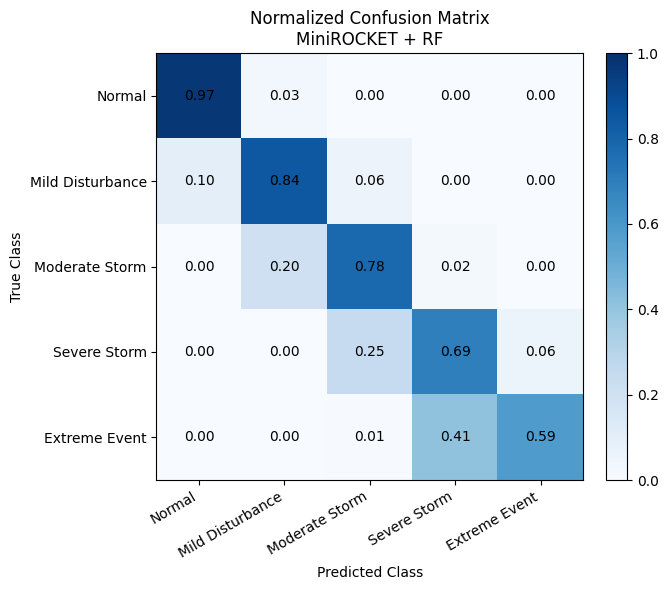

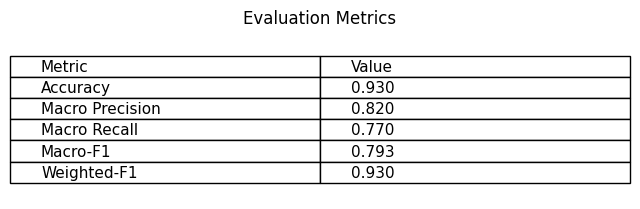

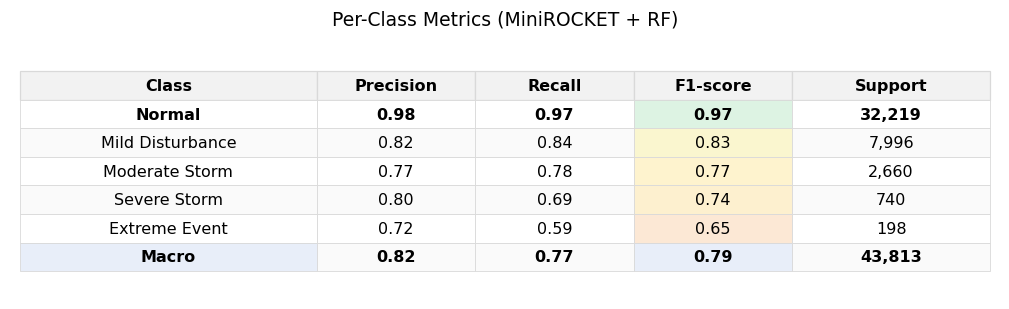

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


cm = np.array([
    [31312,  907,    0,   0,   0],
    [  796, 6749,  451,   0,   0],
    [    0,  541, 2069,  50,   0],
    [    0,    0,  183, 512,  45],
    [    0,    0,    1,  81, 116],
], dtype=int)

class_names = [
    "Normal",
    "Mild Disturbance",
    "Moderate Storm",
    "Severe Storm",
    "Extreme Event"
]


metrics = {
    "Accuracy": 0.93,
    "Macro-F1": 0.793038821845551,
    "Weighted-F1": 0.93,
    "Macro Recall": 0.77,
    "Macro Precision": 0.82,
}

MODEL_TAG  = "minirocket_rf"
TITLE_LINE = "MiniROCKET + RF"


row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm / np.maximum(row_sums, 1)

plt.figure(figsize=(7.2, 6.0))
im = plt.imshow(cm_norm, cmap="Blues", vmin=0.0, vmax=1.0)

plt.title(f"Normalized Confusion Matrix\n{TITLE_LINE}")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

plt.xticks(range(len(class_names)), class_names, rotation=30, ha="right")
plt.yticks(range(len(class_names)), class_names)

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(
            j, i,
            f"{cm_norm[i, j]:.2f}",
            ha="center",
            va="center",
            fontsize=10
        )

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(f"{MODEL_TAG}_test_confusion_matrix_normalized.png", dpi=200)
plt.show()

metrics_df = pd.DataFrame(
    [{"Metric": k, "Value": v} for k, v in metrics.items()]
).sort_values("Metric").reset_index(drop=True)

metrics_df["Value"] = metrics_df["Value"].map(lambda x: f"{x:.3f}")

fig, ax = plt.subplots(figsize=(6.5, 2.2))
ax.axis("off")

table = ax.table(
    cellText=metrics_df.values,
    colLabels=metrics_df.columns,
    cellLoc="left",
    colLoc="left",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.35)

ax.set_title("Evaluation Metrics", pad=12)
plt.tight_layout()
plt.savefig(f"{MODEL_TAG}_test_metrics_table.png", dpi=200)
plt.show()


tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
fn = cm.sum(axis=1) - tp

precision = tp / np.maximum(tp + fp, 1)
recall    = tp / np.maximum(tp + fn, 1)
f1        = 2 * precision * recall / np.maximum(precision + recall, 1e-12)
support   = cm.sum(axis=1)

df = pd.DataFrame({
    "Class": class_names,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "Support": support
})

macro = pd.DataFrame([{
    "Class": "Macro",
    "Precision": df["Precision"].mean(),
    "Recall": df["Recall"].mean(),
    "F1-score": df["F1-score"].mean(),
    "Support": int(df["Support"].sum())
}])

df2 = pd.concat([df, macro], ignore_index=True)

df_fmt = df2.copy()
for c in ["Precision", "Recall", "F1-score"]:
    df_fmt[c] = df_fmt[c].map(lambda x: f"{x:.2f}")
df_fmt["Support"] = df_fmt["Support"].map(
    lambda x: f"{int(x):,}" if isinstance(x, (int, np.integer)) else f"{x:,}"
)

def lerp(a, b, t):
    return a + (b - a) * t

def hex_to_rgb(h):
    h = h.lstrip("#")
    return np.array([int(h[i:i+2], 16) for i in (0, 2, 4)], dtype=float)

def rgb_to_hex(rgb):
    rgb = np.clip(rgb, 0, 255).astype(int)
    return "#{:02x}{:02x}{:02x}".format(*rgb)

C_LOW  = hex_to_rgb("#FCE8D5")
C_MID  = hex_to_rgb("#FFF7CC")
C_HIGH = hex_to_rgb("#DDF3E3")

def f1_color(v, vmin=None, vmax=None):
    if vmin is None: vmin = float(np.min(f1))
    if vmax is None: vmax = float(np.max(f1))
    t = 0.0 if vmax == vmin else (v - vmin) / (vmax - vmin)
    if t < 0.5:
        rgb = lerp(C_LOW, C_MID, t / 0.5)
    else:
        rgb = lerp(C_MID, C_HIGH, (t - 0.5) / 0.5)
    return rgb_to_hex(rgb)

fig, ax = plt.subplots(figsize=(10.2, 3.2))
ax.axis("off")

col_labels = list(df_fmt.columns)
cell_text  = df_fmt.values.tolist()

table = ax.table(
    cellText=cell_text,
    colLabels=col_labels,
    loc="center",
    cellLoc="center",
    colLoc="center",
)

table.auto_set_font_size(False)
table.set_fontsize(11.5)
table.scale(1, 1.65)

col_widths = [0.30, 0.16, 0.16, 0.16, 0.20]
for c, w in enumerate(col_widths):
    for r in range(len(df_fmt) + 1):
        table[(r, c)].set_width(w)

EDGE = "#D9D9D9"
for (r, c), cell in table.get_celld().items():
    cell.set_edgecolor(EDGE)
    cell.set_linewidth(0.6)

    if r == 0:
        cell.set_facecolor("#F2F2F2")
        cell.set_text_props(weight="bold", color="black")
        cell.set_linewidth(0.9)
    else:
        cell.set_facecolor("#FFFFFF" if r % 2 == 1 else "#FAFAFA")

support_col = col_labels.index("Support")
for r in range(1, len(df_fmt) + 1):
    table[(r, support_col)]._loc = "right"
    table[(r, support_col)].PAD = 0.02

f1_col = col_labels.index("F1-score")
best_idx = int(np.argmax(f1))

for i in range(len(df_fmt)):
    r = i + 1
    if df2.loc[i, "Class"] == "Macro":
        table[(r, f1_col)].set_facecolor("#E8EEF9")
        table[(r, 0)].set_text_props(weight="bold")
        table[(r, 0)].set_facecolor("#E8EEF9")
        for cc in range(1, len(col_labels)):
            table[(r, cc)].set_text_props(weight="bold")
        continue

    v = float(df2.loc[i, "F1-score"])
    table[(r, f1_col)].set_facecolor(f1_color(v))

    if i == best_idx:
        for cc in range(len(col_labels)):
            table[(r, cc)].set_text_props(weight="bold")

ax.set_title(f"Per-Class Metrics ({TITLE_LINE})", fontsize=13.5, pad=14)

plt.tight_layout()
plt.savefig(
    f"{MODEL_TAG}_test_per_class_metrics_ultra.png",
    dpi=350,
    bbox_inches="tight",
    facecolor="white"
)
plt.show()


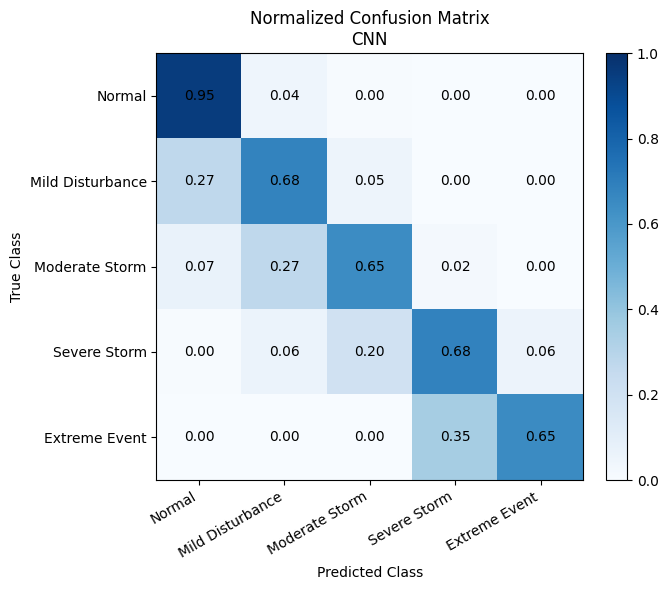

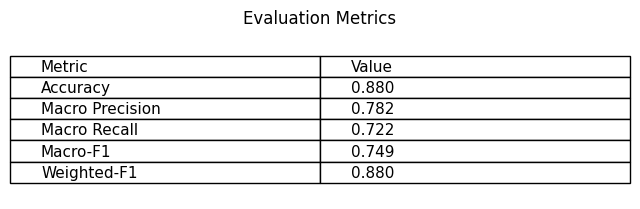

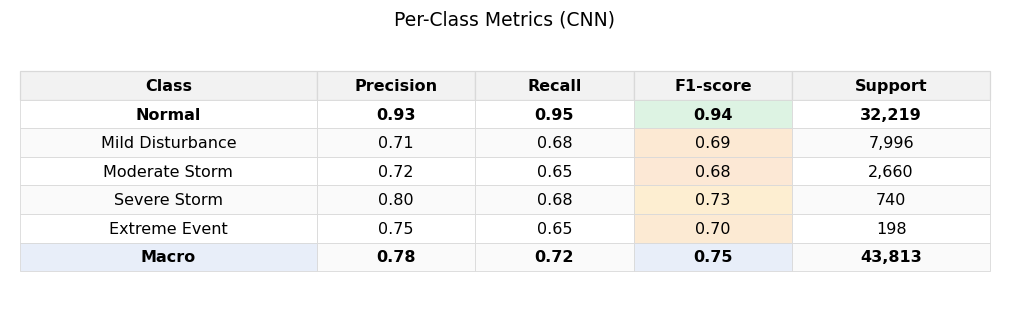

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


cm = np.array([
    [30667, 1415,  132,   5,   0],
    [ 2167, 5418,  400,  11,   0],
    [  179,  720, 1718,  43,   0],
    [    3,   45,  146, 503,  43],
    [    0,    0,    0,  69, 129],
], dtype=int)

class_names = [
    "Normal",
    "Mild Disturbance",
    "Moderate Storm",
    "Severe Storm",
    "Extreme Event"
]


metrics = {
    "Accuracy": 0.88,
    "Macro-F1": 0.74914806692127,
    "Weighted-F1": 0.88,
    "Macro Recall": (0.95 + 0.68 + 0.65 + 0.68 + 0.65) / 5.0,
    "Macro Precision": (0.93 + 0.71 + 0.72 + 0.80 + 0.75) / 5.0,
}

MODEL_TAG  = "cnn"
TITLE_LINE = "CNN"

row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm / np.maximum(row_sums, 1)

plt.figure(figsize=(7.2, 6.0))
im = plt.imshow(cm_norm, cmap="Blues", vmin=0.0, vmax=1.0)

plt.title(f"Normalized Confusion Matrix\n{TITLE_LINE}")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

plt.xticks(range(len(class_names)), class_names, rotation=30, ha="right")
plt.yticks(range(len(class_names)), class_names)

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(
            j, i,
            f"{cm_norm[i, j]:.2f}",
            ha="center",
            va="center",
            fontsize=10
        )

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(f"{MODEL_TAG}_test_confusion_matrix_normalized.png", dpi=200)
plt.show()


metrics_df = pd.DataFrame(
    [{"Metric": k, "Value": v} for k, v in metrics.items()]
).sort_values("Metric").reset_index(drop=True)

metrics_df["Value"] = metrics_df["Value"].map(lambda x: f"{x:.3f}")

fig, ax = plt.subplots(figsize=(6.5, 2.2))
ax.axis("off")

table = ax.table(
    cellText=metrics_df.values,
    colLabels=metrics_df.columns,
    cellLoc="left",
    colLoc="left",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.35)

ax.set_title("Evaluation Metrics", pad=12)
plt.tight_layout()
plt.savefig(f"{MODEL_TAG}_test_metrics_table.png", dpi=200)
plt.show()


tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
fn = cm.sum(axis=1) - tp

precision = tp / np.maximum(tp + fp, 1)
recall    = tp / np.maximum(tp + fn, 1)
f1        = 2 * precision * recall / np.maximum(precision + recall, 1e-12)
support   = cm.sum(axis=1)

df = pd.DataFrame({
    "Class": class_names,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "Support": support
})

macro = pd.DataFrame([{
    "Class": "Macro",
    "Precision": df["Precision"].mean(),
    "Recall": df["Recall"].mean(),
    "F1-score": df["F1-score"].mean(),
    "Support": int(df["Support"].sum())
}])

df2 = pd.concat([df, macro], ignore_index=True)

df_fmt = df2.copy()
for c in ["Precision", "Recall", "F1-score"]:
    df_fmt[c] = df_fmt[c].map(lambda x: f"{x:.2f}")
df_fmt["Support"] = df_fmt["Support"].map(
    lambda x: f"{int(x):,}" if isinstance(x, (int, np.integer)) else f"{x:,}"
)

def lerp(a, b, t):
    return a + (b - a) * t

def hex_to_rgb(h):
    h = h.lstrip("#")
    return np.array([int(h[i:i+2], 16) for i in (0, 2, 4)], dtype=float)

def rgb_to_hex(rgb):
    rgb = np.clip(rgb, 0, 255).astype(int)
    return "#{:02x}{:02x}{:02x}".format(*rgb)

C_LOW  = hex_to_rgb("#FCE8D5")
C_MID  = hex_to_rgb("#FFF7CC")
C_HIGH = hex_to_rgb("#DDF3E3")

def f1_color(v, vmin=None, vmax=None):
    if vmin is None: vmin = float(np.min(f1))
    if vmax is None: vmax = float(np.max(f1))
    t = 0.0 if vmax == vmin else (v - vmin) / (vmax - vmin)
    if t < 0.5:
        rgb = lerp(C_LOW, C_MID, t / 0.5)
    else:
        rgb = lerp(C_MID, C_HIGH, (t - 0.5) / 0.5)
    return rgb_to_hex(rgb)

fig, ax = plt.subplots(figsize=(10.2, 3.2))
ax.axis("off")

col_labels = list(df_fmt.columns)
cell_text  = df_fmt.values.tolist()

table = ax.table(
    cellText=cell_text,
    colLabels=col_labels,
    loc="center",
    cellLoc="center",
    colLoc="center",
)

table.auto_set_font_size(False)
table.set_fontsize(11.5)
table.scale(1, 1.65)

col_widths = [0.30, 0.16, 0.16, 0.16, 0.20]
for c, w in enumerate(col_widths):
    for r in range(len(df_fmt) + 1):
        table[(r, c)].set_width(w)

EDGE = "#D9D9D9"
for (r, c), cell in table.get_celld().items():
    cell.set_edgecolor(EDGE)
    cell.set_linewidth(0.6)

    if r == 0:
        cell.set_facecolor("#F2F2F2")
        cell.set_text_props(weight="bold", color="black")
        cell.set_linewidth(0.9)
    else:
        cell.set_facecolor("#FFFFFF" if r % 2 == 1 else "#FAFAFA")

support_col = col_labels.index("Support")
for r in range(1, len(df_fmt) + 1):
    table[(r, support_col)]._loc = "right"
    table[(r, support_col)].PAD = 0.02

f1_col = col_labels.index("F1-score")
best_idx = int(np.argmax(f1))

for i in range(len(df_fmt)):
    r = i + 1
    if df2.loc[i, "Class"] == "Macro":
        table[(r, f1_col)].set_facecolor("#E8EEF9")
        table[(r, 0)].set_text_props(weight="bold")
        table[(r, 0)].set_facecolor("#E8EEF9")
        for cc in range(1, len(col_labels)):
            table[(r, cc)].set_text_props(weight="bold")
        continue

    v = float(df2.loc[i, "F1-score"])
    table[(r, f1_col)].set_facecolor(f1_color(v))

    if i == best_idx:
        for cc in range(len(col_labels)):
            table[(r, cc)].set_text_props(weight="bold")

ax.set_title(f"Per-Class Metrics ({TITLE_LINE})", fontsize=13.5, pad=14)

plt.tight_layout()
plt.savefig(
    f"{MODEL_TAG}_test_per_class_metrics_ultra.png",
    dpi=350,
    bbox_inches="tight",
    facecolor="white"
)
plt.show()
